# Estimation of Autocorrelation Function 

## (2d Ising model on Square Lattice with J > 0)

In [1]:
import numpy as np
import numba as nb

In [2]:
import csv
import pickle
import time
from tqdm.auto import trange

In [4]:
import matplotlib.pyplot as plt

In [5]:
types_corr_k_steps_est = nb.types.Tuple((nb.float64, nb.float64, nb.float64[:]))(nb.float32[:], nb.int64)
@nb.cfunc(types_corr_k_steps_est, parallel=True)
def corr_k_step_est_float(sample_array, k_steps_max):
    """
    Args:
        mc_list: (np.array)
        k_steps: (int)
    Return:
        corr_coef: (float)
    """
    sample_len = len(sample_array)
    num_i_steps = sample_len - k_steps_max
    q_mean = np.mean(sample_array[:num_i_steps])
    q_square_mean = np.mean(np.square(sample_array[:num_i_steps]))
    qqk_sum = np.zeros(k_steps_max)
    for i in range(num_i_steps):
        samples_k_sub = sample_array[i:i+k_steps_max+1]
        for j in range(1, k_steps_max+1):
            qqk_sum[j-1] += (samples_k_sub[0] * samples_k_sub[j])
    qqk_array = qqk_sum / num_i_steps
    return (q_mean, q_square_mean, qqk_array)

In [6]:
types_corr_k_steps_est = nb.types.Tuple((nb.float64, nb.float64, nb.float64[:]))(nb.int32[:], nb.int64)
@nb.cfunc(types_corr_k_steps_est, parallel=True)
def corr_k_step_est_int(sample_array, k_steps_max):
    """
    Args:
        mc_list: (np.array)
        k_steps: (int)
    Return:
        corr_coef: (float)
    """
    sample_len = len(sample_array)
    num_i_steps = sample_len - k_steps_max
    q_mean = np.mean(sample_array[:num_i_steps])
    q_square_mean = np.mean(np.square(sample_array[:num_i_steps]))
    qqk_sum = np.zeros(k_steps_max)
    for i in range(num_i_steps):
        samples_k_sub = sample_array[i:i+k_steps_max+1]
        for j in range(1, k_steps_max+1):
            qqk_sum[j-1] += (samples_k_sub[0] * samples_k_sub[j])
    qqk_array = qqk_sum / num_i_steps
    return (q_mean, q_square_mean, qqk_array)

In [7]:
@nb.njit(parallel=True)
def autocorr_mc_mean_est(mc_array, k_steps_max):
    m_times = mc_array.shape[0]
    qqk_mean_mc, qqk_mean_std_mc = np.zeros(k_steps_max), np.zeros(k_steps_max)
    q_mean_array, q_square_mean_array, qqk_double_array = np.zeros(m_times), np.zeros(m_times), np.zeros((m_times, k_steps_max))
    for i in range(m_times):
        q_mean, q_square_mean, qqk_array = corr_k_step_est_float(mc_array[i], k_steps_max)
        q_mean_array[i] = q_mean
        q_square_mean_array[i] = q_square_mean
        qqk_double_array[i] = qqk_array
    for i in range(k_steps_max):
        qqk_mean_mc_i = np.mean(qqk_double_array[:, i])
        qqk_mean_std_mc_i = np.std(qqk_double_array[:, i])
        qqk_mean_mc[i] = qqk_mean_mc_i
        qqk_mean_std_mc[i] = qqk_mean_std_mc_i / np.sqrt(m_times)
    ####################################################
    q_mean_mc = np.mean(q_mean_array)
    q_mean_std_mc = np.std(q_mean_array) / np.sqrt(m_times)
    q_square_mean_mc = np.mean(q_square_mean_array)
    q_square_mean_std_mc = np.std(q_square_mean_array) / np.sqrt(m_times)
    ####################################################
    q_mean = (q_mean_mc, q_mean_std_mc)
    q_square_mean = (q_square_mean_mc, q_square_mean_std_mc)
    qqk_mean = (qqk_mean_mc, qqk_mean_std_mc)
    ####################################################
    autocorr_mc = (qqk_mean_mc - q_mean_mc ** 2) / (q_square_mean_mc - q_mean_mc ** 2) 
    return autocorr_mc, q_mean, q_square_mean, qqk_mean

In [8]:
@nb.njit(parallel=True)
def autocorr_mc_std_est(mc_array, k_steps_max):
    m_times = mc_array.shape[0]
    qqk_mean_mc, qqk_mean_std_mc = np.zeros(k_steps_max), np.zeros(k_steps_max)
    q_mean_array, q_square_mean_array, qqk_double_array = np.zeros((m_times, 1)), np.zeros((m_times, 1)), np.zeros((m_times, k_steps_max))
    autocorr_mc_mean, autocorr_mc_std = np.zeros(k_steps_max), np.zeros(k_steps_max)
    for i in range(m_times):
        q_mean, q_square_mean, qqk_array = corr_k_step_est_float(mc_array[i], k_steps_max)
        q_mean_array[i] = q_mean
        q_square_mean_array[i] = q_square_mean
        qqk_double_array[i] = qqk_array        
    ####################################################
    autocorr_mc_array = (qqk_double_array - q_mean_array ** 2) / (q_square_mean_array - q_mean_array ** 2)
    q_mean_mc = np.mean(q_mean_array)
    q_square_mean_mc = np.mean(q_square_mean_array)
    qqk_mc = np.mean(qqk_double_array)
    for j in range(k_steps_max):
        autocorr_mc_mean[j] = np.mean(autocorr_mc_array[:, j])
        autocorr_mc_std[j] = np.std(autocorr_mc_array[:, j]) / np.sqrt(m_times)
    return autocorr_mc_mean, autocorr_mc_std

-----------
### 4 x 4 Square 2D Ising Model

In [9]:
with open('./data_2d_ising/m_ising2d_square_size_4', 'rb') as file:
    m_2dising_4_j_pos = pickle.load(file)

In [10]:
m_abs_2dising_4_j_pos = np.abs(m_2dising_4_j_pos)

In [11]:
m_abs_2dising_4_j_pos = m_abs_2dising_4_j_pos.reshape((10000, 2500))

In [12]:
time_start = time.time()
autocorr_m_abs_2dising_4_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_4_j_pos, 250)
_, autocorr_m_abs_2dising_4_j_pos_std = autocorr_mc_std_est(m_abs_2dising_4_j_pos, 250)
time_end = time.time()
print(time_end-time_start)

227.38636445999146


In [13]:
autocorr_m_abs_2dising_4_j_pos_mean = np.insert(autocorr_m_abs_2dising_4_j_pos_mean, 0, 1)

In [14]:
autocorr_m_abs_2dising_4_j_pos_std = np.insert(autocorr_m_abs_2dising_4_j_pos_std, 0, 0)

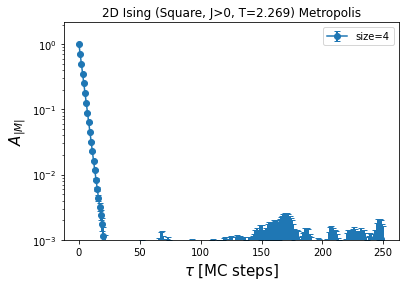

In [49]:
plt.errorbar(x=range(251), y=autocorr_m_abs_2dising_4_j_pos_mean, yerr=autocorr_m_abs_2dising_4_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=4')
plt.yscale("log")
plt.ylim(10**-3)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Metropolis")
plt.legend()

In [17]:
m_abs_2dising_4_j_pos_mean = np.mean(m_abs_2dising_4_j_pos)

In [18]:
print(f"|m| of size 4 is: {m_abs_2dising_4_j_pos_mean:.3f}.")

|m| of size 4 is: 0.844.


In [58]:
autocorr_time_size_4 = np.sum(autocorr_m_abs_2dising_4_j_pos_mean[:30]) - 1/2

In [59]:
print(f"autocorr time of size 4 is: {autocorr_time_size_4:.3f}.")

autocorr time of size 4 is: 2.919.


----
### Size = 8

In [19]:
with open('./data_2d_ising/m_ising2d_square_size_8', 'rb') as file:
    m_2dising_8_j_pos = pickle.load(file)

In [20]:
m_abs_2dising_8_j_pos = np.abs(m_2dising_8_j_pos)

In [21]:
m_abs_2dising_8_j_pos_mean = np.mean(m_abs_2dising_8_j_pos)

In [22]:
print(f"|m| of size 8 is: {m_abs_2dising_8_j_pos_mean:.3f}.")

|m| of size 8 is: 0.777.


In [23]:
m_abs_2dising_8_j_pos = m_abs_2dising_8_j_pos.reshape((10000, 2500))

In [24]:
time_start = time.time()
autocorr_m_abs_2dising_8_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_8_j_pos, 250)
_, autocorr_m_abs_2dising_8_j_pos_std = autocorr_mc_std_est(m_abs_2dising_8_j_pos, 250)
time_end = time.time()
print(time_end-time_start)

166.1110646724701


In [26]:
autocorr_m_abs_2dising_8_j_pos_mean = np.insert(autocorr_m_abs_2dising_8_j_pos_mean, 0, 1)

In [27]:
autocorr_m_abs_2dising_8_j_pos_std = np.insert(autocorr_m_abs_2dising_8_j_pos_std, 0, 0)

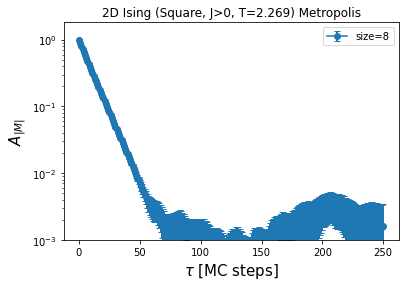

In [30]:
plt.errorbar(x=range(251), y=autocorr_m_abs_2dising_8_j_pos_mean, yerr=autocorr_m_abs_2dising_8_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=8')
plt.yscale("log")
plt.ylim(10**-3)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Metropolis")
plt.legend()

In [62]:
autocorr_time_size_8 = np.sum(autocorr_m_abs_2dising_8_j_pos_mean[:70]) - 1/2

In [63]:
print(f"autocorr time of size 8 is: {autocorr_time_size_8:.3f}.")

autocorr time of size 8 is: 9.715.


-----------
### Size = 16

In [31]:
with open('./data_2d_ising/m_ising2d_square_size_16', 'rb') as file:
    m_2dising_16_j_pos = pickle.load(file)

In [32]:
m_abs_2dising_16_j_pos = np.abs(m_2dising_16_j_pos)

In [33]:
m_abs_2dising_16_j_pos_mean = np.mean(m_abs_2dising_16_j_pos)

In [34]:
print(f"|m| of size 16 is: {m_abs_2dising_16_j_pos_mean:.3f}.")

|m| of size 16 is: 0.713.


In [35]:
m_abs_2dising_16_j_pos = m_abs_2dising_16_j_pos.reshape((10000, 2500))

In [36]:
time_start = time.time()
autocorr_m_abs_2dising_16_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_16_j_pos, 250)
_, autocorr_m_abs_2dising_16_j_pos_std = autocorr_mc_std_est(m_abs_2dising_16_j_pos, 250)
time_end = time.time()
print(time_end-time_start)

163.22756791114807


In [37]:
autocorr_m_abs_2dising_16_j_pos_mean = np.insert(autocorr_m_abs_2dising_16_j_pos_mean, 0, 1)

In [38]:
autocorr_m_abs_2dising_16_j_pos_std = np.insert(autocorr_m_abs_2dising_16_j_pos_std, 0, 0)

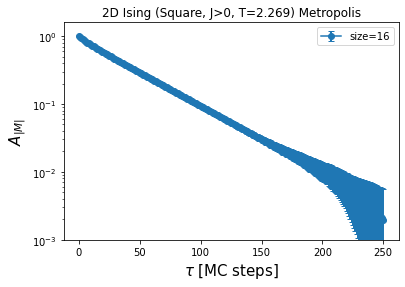

In [39]:
plt.errorbar(x=range(251), y=autocorr_m_abs_2dising_16_j_pos_mean, yerr=autocorr_m_abs_2dising_16_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=16')
plt.yscale("log")
plt.ylim(10**-3)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Metropolis")
plt.legend()

In [64]:
autocorr_time_size_16 = np.sum(autocorr_m_abs_2dising_16_j_pos_mean[:210]) - 1/2

In [65]:
print(f"autocorr time of size 16 is: {autocorr_time_size_16:.3f}.")

autocorr time of size 16 is: 40.037.


-----------
### Size = 32

In [40]:
with open('./data_2d_ising/m_ising2d_square_size_32', 'rb') as file:
    m_2dising_32_j_pos = pickle.load(file)

In [41]:
m_abs_2dising_32_j_pos = np.abs(m_2dising_32_j_pos)

In [42]:
m_abs_2dising_32_j_pos_mean = np.mean(m_abs_2dising_32_j_pos)

In [43]:
print(f"|m| of size 32 is: {m_abs_2dising_32_j_pos_mean:.3f}.")

|m| of size 32 is: 0.654.


In [44]:
m_abs_2dising_32_j_pos = m_abs_2dising_32_j_pos.reshape((10000, 2500))

In [45]:
time_start = time.time()
autocorr_m_abs_2dising_32_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_32_j_pos, 250)
_, autocorr_m_abs_2dising_32_j_pos_std = autocorr_mc_std_est(m_abs_2dising_32_j_pos, 250)
time_end = time.time()
print(time_end-time_start)

196.88511085510254


In [46]:
autocorr_m_abs_2dising_32_j_pos_mean = np.insert(autocorr_m_abs_2dising_32_j_pos_mean, 0, 1)

In [47]:
autocorr_m_abs_2dising_32_j_pos_std = np.insert(autocorr_m_abs_2dising_32_j_pos_std, 0, 0)

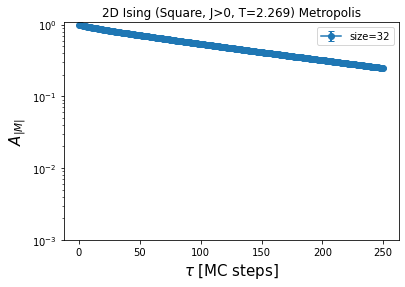

In [48]:
plt.errorbar(x=range(251), y=autocorr_m_abs_2dising_32_j_pos_mean, yerr=autocorr_m_abs_2dising_32_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=32')
plt.yscale("log")
plt.ylim(10**-3)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Metropolis")
plt.legend()

In [66]:
autocorr_time_size_32 = np.sum(autocorr_m_abs_2dising_32_j_pos_mean) - 1/2

In [67]:
print(f"autocorr time of size 32 is: {autocorr_time_size_32:.3f}.")

autocorr time of size 32 is: 128.648.


--------------
#### Summary

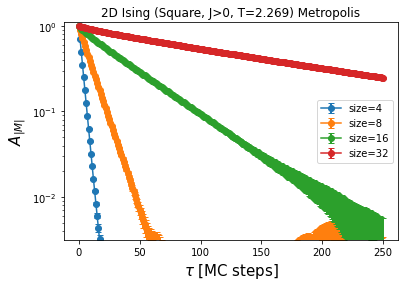

In [52]:
plt.errorbar(x=range(251), y=autocorr_m_abs_2dising_4_j_pos_mean, yerr=autocorr_m_abs_2dising_4_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=4')
plt.errorbar(x=range(251), y=autocorr_m_abs_2dising_8_j_pos_mean, yerr=autocorr_m_abs_2dising_8_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=8')
plt.errorbar(x=range(251), y=autocorr_m_abs_2dising_16_j_pos_mean, yerr=autocorr_m_abs_2dising_16_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=16')
plt.errorbar(x=range(251), y=autocorr_m_abs_2dising_32_j_pos_mean, yerr=autocorr_m_abs_2dising_32_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=32')
plt.yscale("log")
plt.ylim(10**-2.5, 1.1)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Metropolis")
plt.legend()

### Size effect and Dynamical Exponent

In [54]:
size_array = np.array([4, 8, 16, 32])

In [55]:
autocorr_fun_array = np.array([m_abs_2dising_4_j_pos_mean, 
                               m_abs_2dising_8_j_pos_mean,
                               m_abs_2dising_16_j_pos_mean,
                               m_abs_2dising_32_j_pos_mean])

Text(0.5, 1.0, 'Size Effect on Square 2D Ising (J > 0) Metropolis')

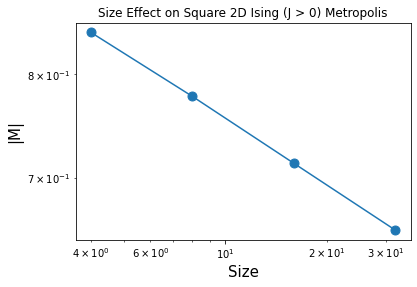

In [57]:
plt.plot(size_array, autocorr_fun_array, '-o', markersize=9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Size", fontsize=15)
plt.ylabel("|M|", fontsize=15)
plt.title("Size Effect on Square 2D Ising (J > 0) Metropolis")

In [68]:
autocorr_time_array = np.array([autocorr_time_size_4, autocorr_time_size_8, 
                                autocorr_time_size_16, autocorr_time_size_32])
size_array = np.array([4, 8, 16, 32])

In [69]:
index_metropolis, bias = np.polyfit(np.log(size_array), np.log(autocorr_time_array), 1)

In [70]:
print(f"index of metropolis is about: {index_metropolis:.3f}.")

index of metropolis is about: 1.843.


Text(0.5, 1.0, 'Metropolis on Ising 2D Square Lattice (J > 0), Z=1.843')

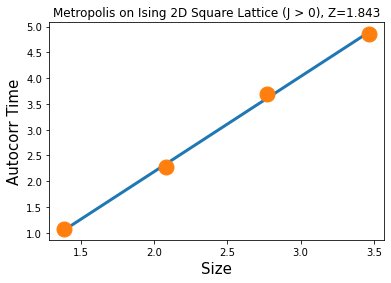

In [71]:
plt.plot(np.log(size_array), index_metropolis*np.log(size_array) + bias, linewidth=3)
plt.plot(np.log(size_array), np.log(autocorr_time_array), 'o', markersize=15)
plt.xlabel("Size", fontsize=15)
plt.ylabel("Autocorr Time", fontsize=15)
plt.title("Metropolis on Ising 2D Square Lattice (J > 0), Z=1.843")

--------------------
## Chain Evolution on Square Lattice (J > 0)

### Size = 4

In [73]:
with open('./data_2d_ising/2dising_square_size_4_pos_j_T_2269_m_1E7.pkl', 'rb') as file:
    m_2dising_size_4_square_pos_j = pickle.load(file)

In [74]:
m_abs_2dising_size_4_square_pos_j = np.abs(m_2dising_size_4_square_pos_j)

In [75]:
m_abs_2dising_size_4_square_pos_j_mean = np.mean(m_abs_2dising_size_4_square_pos_j)

In [76]:
print(f"|m| of size 4 is: {m_abs_2dising_size_4_square_pos_j_mean}.")

|m| of size 4 is: 0.8441501259803772.


In [77]:
m_abs_2dising_size_4_square_pos_j = m_abs_2dising_size_4_square_pos_j.reshape((10000, 1000))

In [78]:
time_start = time.time()
autocorr_m_abs_2dising_size_4_square_pos_j_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_size_4_square_pos_j, 100)
_, autocorr_m_abs_2dising_size_4_square_pos_j_std = autocorr_mc_std_est(m_abs_2dising_size_4_square_pos_j, 100)
time_end = time.time()
print(time_end-time_start)

130.91382122039795


In [79]:
autocorr_m_abs_2dising_size_4_square_pos_j_mean = np.insert(autocorr_m_abs_2dising_size_4_square_pos_j_mean, 0, 1)

In [80]:
autocorr_m_abs_2dising_size_4_square_pos_j_std = np.insert(autocorr_m_abs_2dising_size_4_square_pos_j_std, 0, 0)

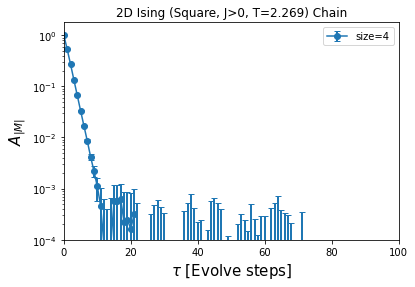

In [81]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_size_4_square_pos_j_mean, yerr=autocorr_m_abs_2dising_size_4_square_pos_j_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=4')
plt.yscale("log")
plt.ylim(10**-4)
plt.xlim(0, 100)
plt.xlabel(r'$\tau$ [Evolve steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Chain")
plt.legend()

In [82]:
autocorr_time_size_4 = np.sum(autocorr_m_abs_2dising_size_4_square_pos_j_mean[:10]) - 1/2

In [83]:
print(f"autocorr time of size 4 is: {autocorr_time_size_4:.3f}.")

autocorr time of size 4 is: 1.573.


-----
### Size = 8

In [84]:
with open('./data_2d_ising/2dising_square_size_8_pos_j_T_2269_m_1E7.pkl', 'rb') as file:
    m_2dising_size_8_square_pos_j = pickle.load(file)

In [85]:
m_abs_2dising_size_8_square_pos_j = np.abs(m_2dising_size_8_square_pos_j)

In [86]:
m_abs_2dising_size_8_square_pos_j_mean = np.mean(m_abs_2dising_size_8_square_pos_j)

In [87]:
print(f"|m| of size 8 is: {m_abs_2dising_size_8_square_pos_j_mean}.")

|m| of size 8 is: 0.7774075269699097.


In [88]:
m_abs_2dising_size_8_square_pos_j = m_abs_2dising_size_8_square_pos_j.reshape((10000, 1000))

In [89]:
time_start = time.time()
autocorr_m_abs_2dising_size_8_square_pos_j_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_size_8_square_pos_j, 100)
_, autocorr_m_abs_2dising_size_8_square_pos_j_std = autocorr_mc_std_est(m_abs_2dising_size_8_square_pos_j, 100)
time_end = time.time()
print(time_end-time_start)

130.12492513656616


In [90]:
autocorr_m_abs_2dising_size_8_square_pos_j_mean = np.insert(autocorr_m_abs_2dising_size_8_square_pos_j_mean, 0, 1)

In [91]:
autocorr_m_abs_2dising_size_8_square_pos_j_std = np.insert(autocorr_m_abs_2dising_size_8_square_pos_j_std, 0, 0)

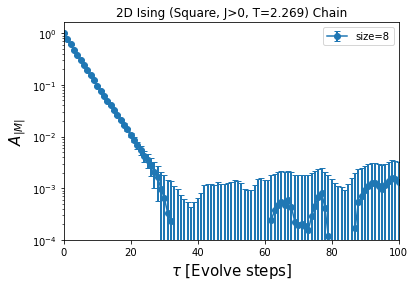

In [92]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_size_8_square_pos_j_mean, yerr=autocorr_m_abs_2dising_size_8_square_pos_j_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=8')
plt.yscale("log")
plt.ylim(10**-4)
plt.xlim(0, 100)
plt.xlabel(r'$\tau$ [Evolve steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Chain")
plt.legend()

In [93]:
autocorr_time_size_8 = np.sum(autocorr_m_abs_2dising_size_8_square_pos_j_mean[:25]) - 1/2

In [94]:
print(f"autocorr time of size 8 is: {autocorr_time_size_8:.3f}.")

autocorr time of size 8 is: 4.218.


-------
### Size = 16

In [95]:
with open('./data_2d_ising/2dising_square_size_16_pos_j_T_2269_m_1E7.pkl', 'rb') as file:
    m_2dising_size_16_square_pos_j = pickle.load(file)

In [96]:
m_abs_2dising_size_16_square_pos_j = np.abs(m_2dising_size_16_square_pos_j)

In [97]:
m_abs_2dising_size_16_square_pos_j_mean = np.mean(m_abs_2dising_size_16_square_pos_j)

In [98]:
print(f"|m| of size 16 is: {m_abs_2dising_size_16_square_pos_j_mean}.")

|m| of size 16 is: 0.7138419151306152.


In [99]:
m_abs_2dising_size_16_square_pos_j = m_abs_2dising_size_16_square_pos_j.reshape((10000, 1000))

In [100]:
time_start = time.time()
autocorr_m_abs_2dising_size_16_square_pos_j_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_size_16_square_pos_j, 100)
_, autocorr_m_abs_2dising_size_16_square_pos_j_std = autocorr_mc_std_est(m_abs_2dising_size_16_square_pos_j, 100)
time_end = time.time()
print(time_end-time_start)

133.13597750663757


In [101]:
autocorr_m_abs_2dising_size_16_square_pos_j_mean = np.insert(autocorr_m_abs_2dising_size_16_square_pos_j_mean, 0, 1)

In [102]:
autocorr_m_abs_2dising_size_16_square_pos_j_std = np.insert(autocorr_m_abs_2dising_size_16_square_pos_j_std, 0, 0)

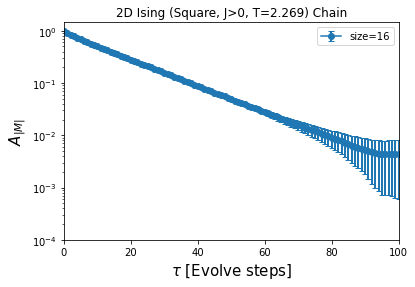

In [103]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_size_16_square_pos_j_mean, yerr=autocorr_m_abs_2dising_size_16_square_pos_j_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=16')
plt.yscale("log")
plt.ylim(10**-4)
plt.xlim(0, 100)
plt.xlabel(r'$\tau$ [Evolve steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Chain")
plt.legend()

In [104]:
autocorr_time_size_16 = np.sum(autocorr_m_abs_2dising_size_16_square_pos_j_mean[:70]) - 1/2

In [105]:
print(f"autocorr time of size 16 is: {autocorr_time_size_16:.3f}.")

autocorr time of size 16 is: 15.463.


-----
### Size = 32

In [106]:
with open('./data_2d_ising/2dising_square_size_32_pos_j_T_2269_m_5E6.pkl', 'rb') as file:
    m_2dising_size_32_square_pos_j = pickle.load(file)

In [107]:
m_abs_2dising_size_32_square_pos_j = np.abs(m_2dising_size_32_square_pos_j)

In [108]:
m_abs_2dising_size_32_square_pos_j_mean = np.mean(m_abs_2dising_size_32_square_pos_j)

In [109]:
print(f"|m| of size 32 is: {m_abs_2dising_size_32_square_pos_j_mean}.")

|m| of size 32 is: 0.6536909937858582.


In [110]:
m_abs_2dising_size_32_square_pos_j = m_abs_2dising_size_32_square_pos_j.reshape((10000, 500))

In [111]:
time_start = time.time()
autocorr_m_abs_2dising_size_32_square_pos_j_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_size_32_square_pos_j, 50)
_, autocorr_m_abs_2dising_size_32_square_pos_j_std = autocorr_mc_std_est(m_abs_2dising_size_32_square_pos_j, 50)
time_end = time.time()
print(time_end-time_start)

107.06799817085266


In [112]:
autocorr_m_abs_2dising_size_32_square_pos_j_mean = np.insert(autocorr_m_abs_2dising_size_32_square_pos_j_mean, 0, 1)

In [113]:
autocorr_m_abs_2dising_size_32_square_pos_j_std = np.insert(autocorr_m_abs_2dising_size_32_square_pos_j_std, 0, 0)

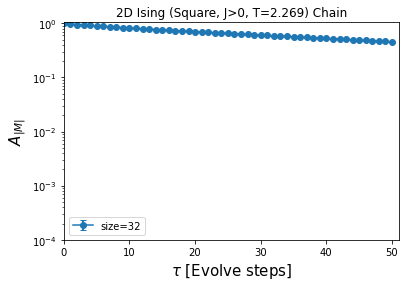

In [125]:
plt.errorbar(x=range(51), y=autocorr_m_abs_2dising_size_32_square_pos_j_mean, yerr=autocorr_m_abs_2dising_size_32_square_pos_j_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=32')
plt.yscale("log")
plt.ylim(10**-4)
plt.xlim(0, 51)
plt.xlabel(r'$\tau$ [Evolve steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Chain")
plt.legend()

In [115]:
autocorr_time_size_32 = np.sum(autocorr_m_abs_2dising_size_32_square_pos_j_mean) - 1/2

In [116]:
print(f"autocorr time of size 32 is: {autocorr_time_size_32:.3f}.")

autocorr time of size 32 is: 33.853.


-------
### dynamical exponent

In [117]:
autocorr_time_array = np.array([autocorr_time_size_4, autocorr_time_size_8, 
                                autocorr_time_size_16, autocorr_time_size_32])
size_array = np.array([4, 8, 16, 32])

In [118]:
index_chain, bias = np.polyfit(np.log(size_array), np.log(autocorr_time_array), 1)

In [119]:
print(f"index of chain evolution is about: {index_chain:.3f}.")

index of chain evolution is about: 1.516.


Text(0.5, 1.0, 'Chain on Ising 2D Square Lattice (J > 0), Z=1.516')

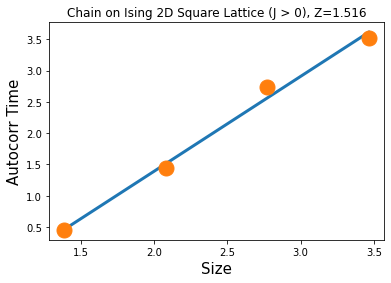

In [120]:
plt.plot(np.log(size_array), index_chain*np.log(size_array) + bias, linewidth=3)
plt.plot(np.log(size_array), np.log(autocorr_time_array), 'o', markersize=15)
plt.xlabel("Size", fontsize=15)
plt.ylabel("Autocorr Time", fontsize=15)
plt.title("Chain on Ising 2D Square Lattice (J > 0), Z=1.516")

-----
### Size effects

In [121]:
autocorr_fun_array = np.array([m_abs_2dising_size_4_square_pos_j_mean, 
                               m_abs_2dising_size_8_square_pos_j_mean,
                               m_abs_2dising_size_16_square_pos_j_mean,
                               m_abs_2dising_size_32_square_pos_j_mean])

In [122]:
coef_autocorr, bias = np. polyfit(size_array, autocorr_fun_array, 1)

Text(0.5, 1.0, 'Size effect on 2D Ising Square Lattice (J < 0)')

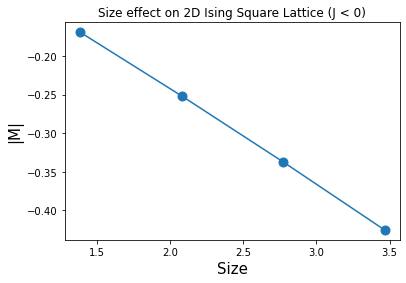

In [123]:
#plt.plot(size_array, coef_autocorr*size_array + bias, linewidth=3)
plt.plot(np.log(size_array), np.log(autocorr_fun_array), '-o', markersize=9)
plt.xlabel("Size", fontsize=15)
plt.ylabel("|M|", fontsize=15)
plt.title("Size effect on 2D Ising Square Lattice (J < 0)")